# Exercises

In [1]:
%pip install numpy pymc arviz matplotlib mplcursors

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from mplcursors import cursor  # separate package must be installed

# Disable C compilation by using the Python-only mode:
import pytensor
pytensor.config.cxx = ""

import os
os.environ['PYTENSOR_FLAGS'] = 'cxx='

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Exercise 1: Negative Binominal Distribution Derivation

### a)

$$
\begin{align}
\lambda &= \frac{r(1-p)}{p}\\
\frac{\lambda}{r} &= \frac{1 - p}{p}\\
\frac{\lambda}{r} &= \frac{1}{p} - 1\\
\frac{\lambda}{r} + 1 &= \frac{1}{p}\\
p\left[\frac{\lambda}{r} + 1\right] &= 1\\
p &= \frac{1}{\frac{\lambda}{r} + 1}\\
\end{align}
$$

$$
p(k|r,\lambda) = \underbrace{\binom{k+r-1}{k}}_{I} \cdot \underbrace{(1-p)^{k}}_{II} \cdot \underbrace{p^{r}}_{III}
$$

$I:$
$$
\binom{k+r-1}{k} = \frac{(k+r-1)!}{k!(k+r-1-k)!} = \frac{(k+r-1)!}{k!(r-1)!}
$$

$II:$
$$
(1 - p)^{k} = (1 - \frac{1}{1 + \frac{\lambda}{r}})^{k} = (1 - \frac{1}{\frac{r + \lambda}{r}})^{k}
= (1 - \frac{r}{r + \lambda})^{k} = (\frac{r + \lambda - r}{r + \lambda})^{k}
= \frac{\lambda^{k}}{(r + \lambda)^{k}}
$$

$III:$
$$
p^{r} = \left[\frac{1}{1 + \frac{\lambda}{r}}\right]^{r} = \frac{1^r}{(1 + \frac{\lambda}{r})^{r}} = \frac{1}{\left(1 + \frac{\lambda}{r}\right)^{r}}
$$

$$
p(k|r,\lambda) = \frac{(k+r-1)!}{k!(r-1)!} \cdot \frac{\lambda^{k}}{(r+\lambda)^{k}} \cdot \frac{1}{(1+\frac{\lambda}{r})^{r}}
$$

For the Variance:

$$
\begin{align}
\mathrm{Var}[k \mid r, p] &= \frac{r \cdot (1-p)}{p^2}\\
r \cdot (1 - p) &= r \cdot \left[1 - \frac{1}{1 + \frac{\lambda}{r}} \right]\\
    &= r \cdot \left[1 - \frac{1}{\frac{r + \lambda}{r}}\right] \\
    &= r \cdot \left[1 - \frac{r}{r+\lambda} \right]\\
    &= r \cdot \left[\frac{(r+\lambda)-r}{r+\lambda}\right] \\
    &= r \cdot \frac{\lambda}{r+\lambda} \\
    &= \frac{r \lambda}{r+\lambda}\\
p^2 &= \left[ \frac{1}{1 + \frac{\lambda}{r}} \right]^2\\
    &= \frac{1}{\left(1 + \frac{\lambda}{r} \right)^2} \\
    &= \frac{1}{\frac{(r+\lambda)^2}{r^2}} \\
    &= \frac{r^2}{(r+\lambda)^2} \\
\mathrm{Var}[k \mid r, \lambda] &= \frac{\frac{r \lambda}{r+\lambda}}{\frac{r^2}{(r+\lambda)^2}} \\
    &= \frac{r \lambda}{(r+\lambda)} \cdot \frac{(r+\lambda)^2}{r^2} \\
    &= \lambda \cdot \frac{r+\lambda}{r} \\
    &= \lambda \cdot \left[\frac{r}{r} + \frac{\lambda}{r}\right] \\
    &= \lambda \cdot \left[1 + \frac{\lambda}{r}\right]
\end{align}
$$

### b)

$$
\begin{align}
\mathrm{Poiss}(k|\lambda) &= \frac{\lambda^k e^{-\lambda}}{k!}\\
\lambda &= \mathbb{E}[k|\lambda] = \mathrm{Var}[k|\lambda]\\
p(k|r, \lambda) &= \frac{(r+k-1)!}{(r-1)!(r+\lambda)^k} \cdot \frac{\lambda^k}{k!} \cdot \frac{1}{\left(1 + \frac{\lambda}{r}\right)^r}\\
\lim_{r \to \infty} p(k|r, \lambda) &= \underbrace{\frac{\infty!}{\infty!}}_{=1} \cdot \frac{\lambda^k}{k!} \cdot \underbrace{\frac{1}{\left(1 + \underbrace{\frac{\lambda}{\infty}}_{=0}\right)^{\infty}}_{=1}}\\
    &= \frac{\lambda^k}{k!}
\end{align}
$$

### c)

???

# Exercse 2: More Toilet Paper Data

In [3]:
toilet_paper_data = np.load('./toilet_paper_data.npy')
toilet_paper_data

array([165.5, 138.7, 139.7, 133.1, 156.4, 118.4, 166.9, 136.9, 149.8,
       143. , 163.5, 121.3, 142.1, 141.4, 159.6, 132.8, 143.9, 135.5,
       146.5, 153. , 132.8, 159.7, 156.8, 152. , 156.8, 137.8, 144.5,
       134.8, 142.8, 152.4, 137.7, 141.2, 137.8, 135.9, 137.9, 145.8,
       132.6, 148.8, 165.9, 154.9, 220. , 135.3, 137. , 166.3, 146.6,
       138.4, 148.3, 171.2, 147.4, 153.4, 149.6, 141.8, 132.3])

### a)

In [4]:
with pm.Model() as toilet_paper_model:
    mu = pm.Normal('mu', mu=np.mean(toilet_paper_data), sigma=np.std(toilet_paper_data, ddof=1))
    sigma = pm.Exponential('sigma', 1 / np.std(toilet_paper_data, ddof=1))
    y = pm.Normal('y', mu, sigma, observed=toilet_paper_data)
    trace = pm.sample( 1000 )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,146.944,2.224,143.394,150.620,0.037,0.026,3695.0,2386.0,1.0
sigma,15.713,1.579,13.106,18.073,0.027,0.020,3603.0,2486.0,1.0


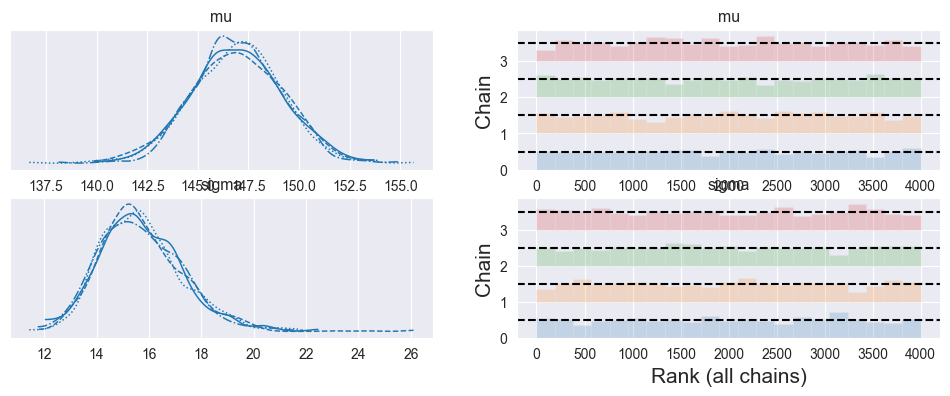

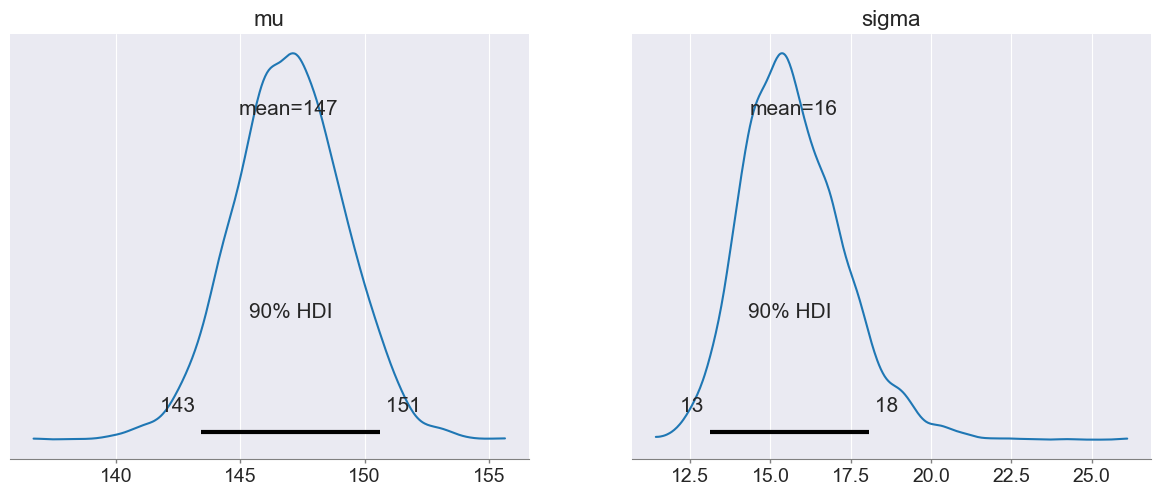

In [5]:
az.plot_trace(trace, kind='rank_bars')
az.plot_posterior(trace, hdi_prob=0.9)
az.summary(trace, hdi_prob=0.9)

**90% Highest Density Interval (HDI):**

- $\mu = [143.287, 150.381]$
- $\sigma = [13.07, 18.087]$

### b)

array([[<Axes: >, None],
       [<Axes: xlabel='mu', ylabel='sigma'>, <Axes: >]], dtype=object)

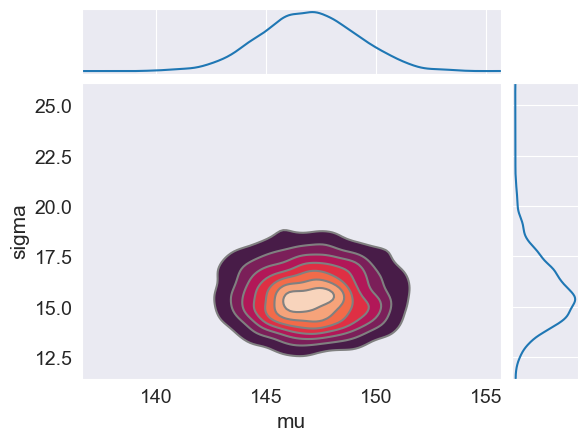

In [6]:
az.plot_pair(trace, kind='kde', marginals=True)

The posterior does indeed look more or less normally distributed.

In [7]:
data = np.array([
    trace.posterior.sigma.values.flatten(),
    trace.posterior.mu.values.flatten()
])

np.cov(data)

array([[ 2.49330093, -0.05716723],
       [-0.05716723,  4.94422117]])

There seems to be a bit of covariance, but its nearly zero and therefore neglectable.

### c)

In [8]:
with toilet_paper_model:
    predictive = pm.sample_posterior_predictive(trace)

Sampling: [y]


In [9]:
y_pred = predictive.posterior_predictive.y.values
y_pred.shape

(4, 1000, 53)

In [10]:
toilet_paper_data.shape

(53,)

In [11]:
y_pred = y_pred.reshape(-1, 53)
y_pred.shape

(4000, 53)

![Root Mean Squared Error](Exercise2-RMSE.png)

In [12]:
rmse = np.sqrt(
    1 / (y_pred.shape[0] * toilet_paper_data.shape[0]) * np.sum(
        np.square(y_pred - toilet_paper_data)
    )
)
print(f"RMSE: {rmse:.4f} kg")

RMSE: 22.1102 kg


The Root Mean Squared Error is around 22.16 kg of toilet paper.

![Mean Absolute Error](Exercise2-MAE.png)

In [13]:
mae = 1 / (y_pred.shape[0] * toilet_paper_data.shape[0]) * np.sum(
    np.abs(y_pred - toilet_paper_data)
)
print(f"MAE: {mae:.4f} kg")

MAE: 16.8467 kg


The Mean Absolute Error is around 16.9 kg of toilet paper.

### d)

**Posterior Predictive Check**

<Axes: xlabel='y'>

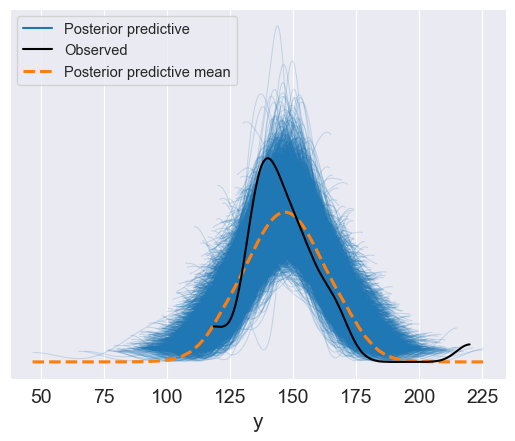

In [14]:
az.plot_ppc(predictive)

The model does not seem to fit the observations very well: The mean should be shifted further to the left. Also, the observations are not normally distributed, but rather right skewed. That said, we might end up with better predictions if we use a non-normal distribution to model the response variable y.

Another possibility as to why the observations are not normally distributed could be that we have outliers in our data. To this end, we can plot the values and see whether we notice any outliers:

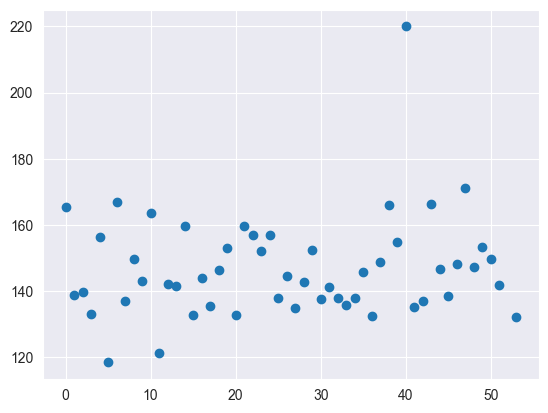

In [15]:
''' %matplotlib tk will open all plots in a new window, where you can scroll, zoom, rotate, and more. '''
# %matplotlib tk

x = np.linspace(0, toilet_paper_data.shape[0], toilet_paper_data.shape[0], dtype=int)
plt.scatter(x, toilet_paper_data)
cursor(hover = True) # shows annotations on hover

![The Outlier in the Toilet Paper Data](Exercise2-Outlier.png)

Lets try again - but without the outlier:

In [16]:
clean_toilet_paper_data = np.delete(toilet_paper_data, 40)
clean_toilet_paper_data.shape

(52,)

In [17]:
with pm.Model() as clean_toilet_paper_model:
    mu = pm.Normal('mu', mu=np.mean(clean_toilet_paper_data), sigma=np.std(clean_toilet_paper_data, ddof=1))
    sigma = pm.Exponential('sigma', 1 / np.std(clean_toilet_paper_data, ddof=1))
    y = pm.Normal('y', mu, sigma, observed=clean_toilet_paper_data)
    clean_trace = pm.sample( 1000 )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [18]:
with clean_toilet_paper_model:
    clean_predictive = pm.sample_posterior_predictive(trace)

Sampling: [y]


<Axes: xlabel='y'>

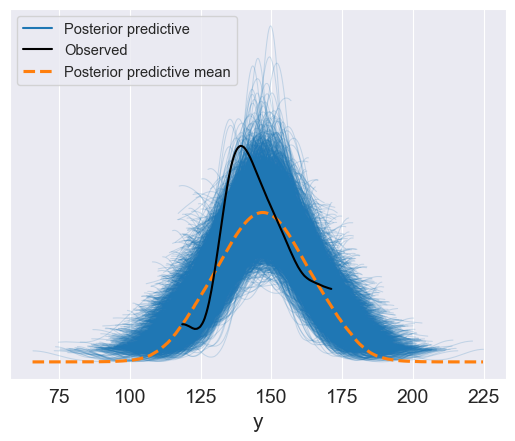

In [19]:
az.plot_ppc(clean_predictive)